### Regression modeling.
> supervised learning regression models are trained to predict Airbnb listing prices based on the prepared dataset

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt

In [ ]:
df_path = Path("../data/processed/airbnb_nyc_cleaned.csv")
df = pd.read_csv(df_path)
df.shape

In [ ]:
# target variable
y = df["price"]

In [ ]:
# feature variables
X = df.drop(
    columns=[
        "price",
        "id",
        "host_id",
        "name",
        "host_name"
    ]
)

X.shape

In [ ]:
# as regression requires only numerical features, i will one hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)
X.shape

In [ ]:
# split data into training and testing sets, 80% training, 20% testing

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [ ]:
# train linear regression model

lr = LinearRegression()
lr.fit(X_train, y_train)

In [ ]:
# evaluate linear regression model

y_pred_lr = lr.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

mae_lr, rmse_lr

In [ ]:
# k-fold cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# model stability using k-fold cross-validation

cv_rmse_lr = -cross_val_score(
    lr,
    X_train,
    y_train,
    scoring="neg_root_mean_squared_error",
    cv=cv
)

cv_rmse_lr.mean(), cv_rmse_lr.std()
# high error + high variance = underfitting risk

As EDA showed weak linear correlations, I will try decision tree and random forest models to capture non-linear relationships.

In [ ]:
# train decision tree regressor

dt = DecisionTreeRegressor(
    max_depth=10,
    random_state=42
)

dt.fit(X_train, y_train)

In [ ]:
# evaluate decision tree regressor

y_pred_dt = dt.predict(X_test)

mae_dt = mean_absolute_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))

mae_dt, rmse_dt

In [ ]:
# model stability using k-fold cross-validation

cv_rmse_dt = -cross_val_score(
    dt,
    X_train,
    y_train,
    scoring="neg_root_mean_squared_error",
    cv=cv
)

cv_rmse_dt.mean(), cv_rmse_dt.std()
# Lower training error + higher variance = overfitting risk.

To reduce overfitting (high variance) and improve generalization, I will try a random forest regressor.

In [ ]:
# train random forest regressor

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

In [ ]:
# evaluate random forest regressor

y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

mae_rf, rmse_rf

In [ ]:
# model stability using k-fold cross-validation

cv_rmse_rf = -cross_val_score(
    rf,
    X_train,
    y_train,
    scoring="neg_root_mean_squared_error",
    cv=cv
)

cv_rmse_rf.mean(), cv_rmse_rf.std()
# Lower error + lower variance = better generalization.

### Summarize model performance

In [ ]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Decision Tree", "Random Forest"],
    "MAE": [mae_lr, mae_dt, mae_rf],
    "RMSE": [rmse_lr, rmse_dt, rmse_rf],
    "CV_RMSE_Mean": [
        cv_rmse_lr.mean(),
        cv_rmse_dt.mean(),
        cv_rmse_rf.mean()
    ]
})

In [ ]:
results

### Check features importance from random forest model

In [ ]:
# distance_from_subway
# distance from manhattan center

importances = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

importances.head()

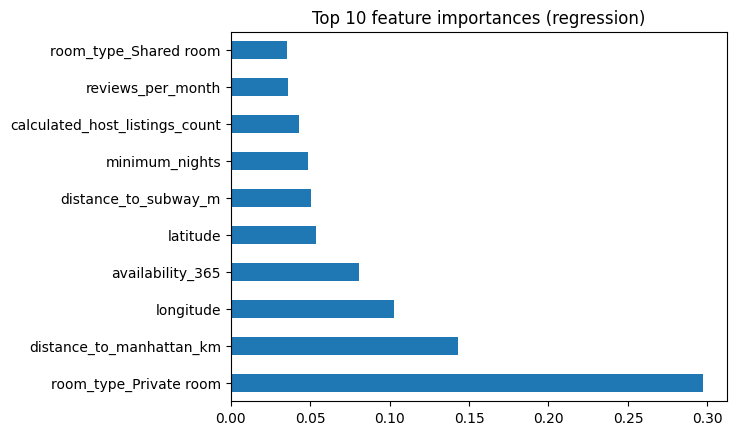

In [23]:
importances.head(10).plot(kind="barh")
plt.title("Top 10 feature importances (regression)")
plt.savefig("../figures/regression/feature_importances_regression.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# save the model
import joblib
from pathlib import Path

MODELS_DIR = Path("../models")

In [ ]:
joblib.dump(rf, MODELS_DIR / "regression.pkl")
joblib.dump(X.columns.tolist(), MODELS_DIR / "X_columns.pkl")